In [1]:
#Import libraries
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import plotly.express as px

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.decomposition import PCA, KernelPCA

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier

from sklearn.metrics import classification_report,f1_score,confusion_matrix,accuracy_score
from sklearn.model_selection import cross_val_score

from sklearn.manifold import TSNE, LocallyLinearEmbedding

import pickle
import optuna

from sklearn.inspection import permutation_importance

/home/aymane/Desktop/3A/LOGIN/AAA/Project/env/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
#get features
initial_data = pd.read_csv('./data/heart_attack_prediction_dataset.csv')
target = initial_data["Heart Attack Risk"]
data = initial_data.drop(columns=["Patient ID", "Heart Attack Risk"])

#get categorical and numerical features
categorical_columns = data.select_dtypes(include=['object']).columns
numerical_columns = data.select_dtypes(exclude=['object']).columns
print(" Columns with numerical values are :", list(numerical_columns),"\n","Columns with categorical values are :", list(categorical_columns))

 Columns with numerical values are : ['Age', 'Cholesterol', 'Heart Rate', 'Diabetes', 'Family History', 'Smoking', 'Obesity', 'Alcohol Consumption', 'Exercise Hours Per Week', 'Previous Heart Problems', 'Medication Use', 'Stress Level', 'Sedentary Hours Per Day', 'Income', 'BMI', 'Triglycerides', 'Physical Activity Days Per Week', 'Sleep Hours Per Day'] 
 Columns with categorical values are : ['Sex', 'Blood Pressure', 'Diet', 'Country', 'Continent', 'Hemisphere']


Some numerical features are binary so we don't need to scale them and we declare them as binary feautures

In [3]:
numerical_columns = ['Age', 'Cholesterol', 'Heart Rate', 'Exercise Hours Per Week', 'Stress Level', 'Sedentary Hours Per Day', 'Income', 'BMI', 'Triglycerides', 'Physical Activity Days Per Week', 'Sleep Hours Per Day']
categorical_columns = [ 'Blood Pressure', 'Diet', 'Country', 'Continent', 'Hemisphere']
data["Sex"] = data["Sex"].map({"Male":1, "Female":0})
binary_columns = ['Previous Heart Problems', 'Medication Use','Smoking', 'Obesity', 'Alcohol Consumption','Family History','Diabetes', 'Sex']

In certain cases, discretizing numerical features can be advantageous when the specific numerical values are less crucial than their general ranges or categories. This process not only simplifies the data complexity but also provides a practical approach to handling these features. So we choose to discritize features : Age, Income, Cholesterol (presenting wide range of numerical values)

### Data preparation

We begin by catorizing some numerical values :

In [4]:
data["Income"].describe()

count      8763.000000
mean     158263.181901
std       80575.190806
min       20062.000000
25%       88310.000000
50%      157866.000000
75%      227749.000000
max      299954.000000
Name: Income, dtype: float64

In [5]:
def categorize_income(income):
    if income > 150000: return 'High income'
    elif 30000 <= income <= 150000: return 'Middle income'
    else:
        return 'Low income'
    
data['Income group'] = data['Income'].apply(categorize_income)   


In [6]:
data["Age"].describe()

count    8763.000000
mean       53.707977
std        21.249509
min        18.000000
25%        35.000000
50%        54.000000
75%        72.000000
max        90.000000
Name: Age, dtype: float64

In [7]:
def categorize_age(age):
    if age < 25:
        return '18-24 years'
    elif age < 35:
        return '25-34 years'
    elif age < 45:
        return '35-44 years'
    elif age < 55:
        return '45-54 years'
    elif age < 65:
        return '55-64 years'
    elif age < 75:
        return '65-74 years'
    else:
        return '75 years and above'
    
data['Age group'] = data['Age'].apply(categorize_age)

In [8]:
data["Cholesterol"].describe()

count    8763.000000
mean      259.877211
std        80.863276
min       120.000000
25%       192.000000
50%       259.000000
75%       330.000000
max       400.000000
Name: Cholesterol, dtype: float64

In [9]:
def categorize_cholesterol(value):
    if value < 200:
        return 'Normal'
    elif value < 240:
        return 'Borderline High'
    elif value < 280:
        return 'High'
    else:
        return 'Very High'
data['Cholesterol group'] = data['Cholesterol'].apply(categorize_cholesterol)

In [10]:
data["Heart Rate"].describe()

count    8763.000000
mean       75.021682
std        20.550948
min        40.000000
25%        57.000000
50%        75.000000
75%        93.000000
max       110.000000
Name: Heart Rate, dtype: float64

In [11]:
def categorize_heart_rate(value):
    if value < 60:
        return 'Low'
    elif value < 80:
        return 'Normal'
    elif value < 100:
        return 'Elevated'
    else:
        return 'High'
data['Heart Rate group'] = data['Heart Rate'].apply(categorize_heart_rate)

In [12]:
features_to_delete = ["Age", "Income", "Cholesterol", "Heart Rate"]
numerical_columns = list(filter(lambda x: x not in features_to_delete, numerical_columns))
categorical_columns = list(categorical_columns)+ ["Age group","Cholesterol group", "Income group", "Heart Rate group"]

As seen before, there are no missing values in our dataset. We only need to scale our data and split it into train/dev/test.

In [13]:
data["Blood Pressure"].head()

0     158/88
1     165/93
2     174/99
3    163/100
4      91/88
Name: Blood Pressure, dtype: object

The feature "Blood Pressure" is expressed as a ratio of two numbers, like "158/88" or "165/93." These values represent blood pressure measurements in millimeters of mercury (mm Hg) and are typically written in the form of "systolic/diastolic" blood pressure. We'll use these values to categorize the blood pressure into different ranges: 

    Normal Blood Pressure:
        Systolic Pressure: Less than 120 mm Hg
        Diastolic Pressure: Less than 80 mm Hg

    Elevated Blood Pressure:
        Systolic Pressure: 120-129 mm Hg
        Diastolic Pressure: Less than 80 mm Hg

    Hypertension Stage 1:
        Systolic Pressure: 130-139 mm Hg
        Diastolic Pressure: 80-89 mm Hg

    Hypertension Stage 2:
        Systolic Pressure: 140 mm Hg or higher
        Diastolic Pressure: 90 mm Hg or higher

    Hypertensive Crisis:
        Systolic Pressure: Higher than 180 mm Hg
        Diastolic Pressure: Higher than 120 mm Hg

In [14]:
# Function to categorize blood pressure
def categorize_blood_pressure(blood_pressure):
    systolic, diastolic = map(int, blood_pressure.split('/'))
    if systolic < 120 or diastolic < 80:
        return 'Normal'
    elif systolic < 130 or diastolic < 80:
        return 'Elevated'
    elif systolic < 140 or diastolic < 90:
        return 'Hypertension Stage 1'
    elif systolic >= 140 or diastolic >= 90:
        return 'Hypertension Stage 2'
    else:
        return 'Unknown'


data['Blood Pressure group'] = data['Blood Pressure'].apply(categorize_blood_pressure)

data['Blood Pressure group'].value_counts()

categorical_columns.remove("Blood Pressure")
categorical_columns.append("Blood Pressure group")


We can see that many patients suffer from high blood pressure

Let's apply OneHotEncoder to categorical values

In [15]:
encoder = OneHotEncoder(sparse_output=False, categories='auto')
categorical_encoded = encoder.fit_transform(data[categorical_columns])
column_names = encoder.get_feature_names_out(categorical_columns)

categorical_encoded = pd.DataFrame(categorical_encoded, columns=column_names)
data_encoded = pd.concat([data[numerical_columns], data[binary_columns], categorical_encoded], axis=1,ignore_index=True)
data_encoded.columns = list(numerical_columns)+list(binary_columns)+list(categorical_encoded.columns)
data_encoded

,Exercise Hours Per Week,Stress Level,Sedentary Hours Per Day,BMI,Triglycerides,Physical Activity Days Per Week,Sleep Hours Per Day,Previous Heart Problems,Medication Use,Smoking,...,Income group_Low income,Income group_Middle income,Heart Rate group_Elevated,Heart Rate group_High,Heart Rate group_Low,Heart Rate group_Normal,Blood Pressure group_Elevated,Blood Pressure group_Hypertension Stage 1,Blood Pressure group_Hypertension Stage 2,Blood Pressure group_Normal
0,4.168189,9,6.615001,31.251233,286,0,6,0,0,1,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
1,1.813242,1,4.963459,27.194973,235,1,7,1,0,1,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,2.078353,9,9.463426,28.176571,587,4,4,1,1,0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
3,9.828130,9,7.648981,36.464704,378,3,4,1,0,1,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
4,5.804299,6,1.514821,21.809144,231,1,5,1,0,1,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8758,7.917342,8,10.806373,19.655895,67,7,7,1,1,1,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
8759,16.558426,8,3.833038,23.993866,617,4,9,0,0,0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
8760,3.148438,5,2.375214,35.406146,527,4,4,1,0,1,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
8761,3.789950,5,0.029104,27.294020,114,2,8,1,1,1,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0


In [16]:
#We save data in order to be used in Data augmentation file
with open('data/features_encoded.pkl', 'wb') as f:
    pickle.dump(data_encoded, f)
with open('data/target.pkl', 'wb') as f:
    pickle.dump(target, f)

Let's see the correlation between all our features

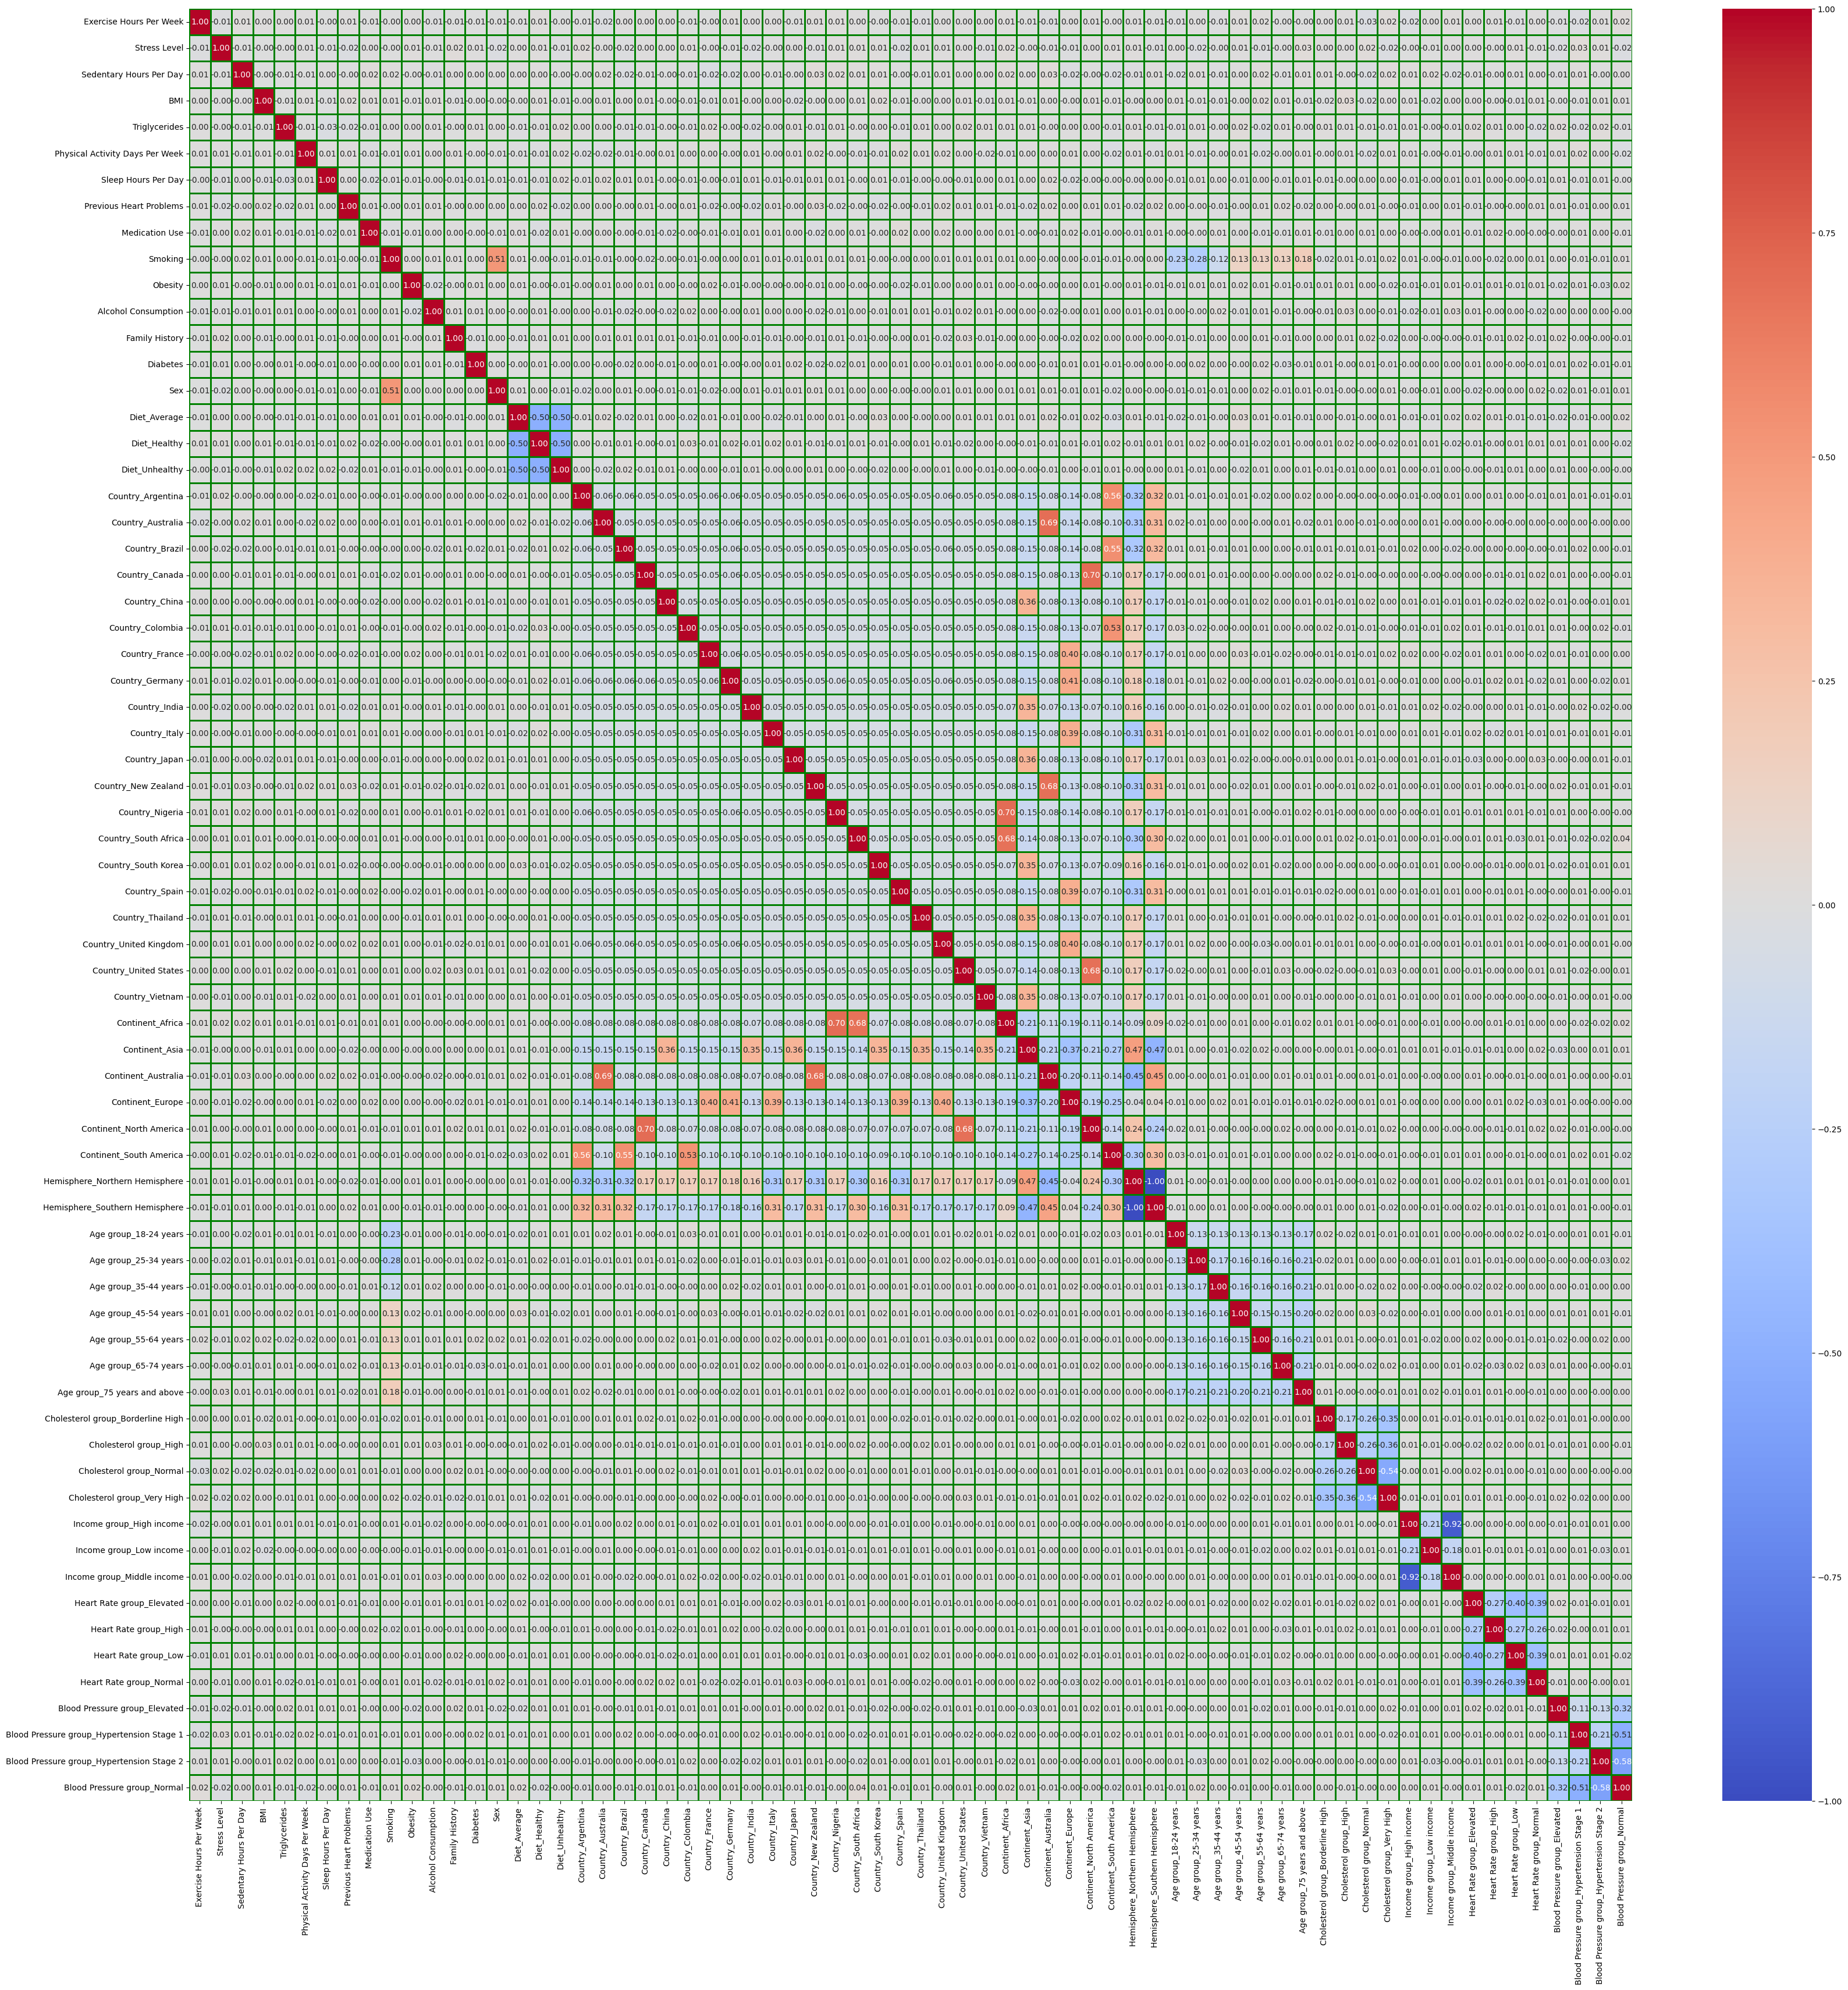

In [17]:
fig = plt.figure(figsize=(40, 40))

corr_map = sns.heatmap(data_encoded.corr(),
                      annot=True,
                      fmt='.2f',
                      cmap='coolwarm',
                      linewidth=2,
                      linecolor='green')

## Definition of the pipeline

We use a standard scaler to scale our numerical values 

In [18]:
num_pipeline = Pipeline([
    ("scaler",StandardScaler())
])

We use a stratified split in order to ensure that the distribution of the target variable is preserved in both the training and test sets.

In [19]:
# Splitting the data
from sklearn.model_selection import StratifiedShuffleSplit
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)


In [20]:
for train_index, test_index in sss.split(data, target):
    train_data, test_data = data_encoded.iloc[train_index], data_encoded.iloc[test_index]
    y_train, y_test = target[train_index], target[test_index]

In [21]:
# Create a ColumnTransformer to apply num_pipeline to numerical columns and keep others unchanged
preprocess_pipeline = ColumnTransformer(
    [
        ("num", num_pipeline, numerical_columns)
    ], remainder="passthrough"
)

X_train = preprocess_pipeline.fit_transform(train_data)
X_test = preprocess_pipeline.transform(test_data)


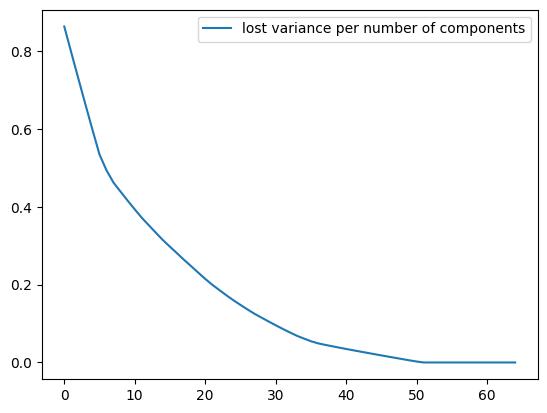

For nb=50, lost variance =  0.008648674156031655


In [22]:
#errors = []
l_variances  = []
for nb in range(2,67):
    pca = PCA(n_components=nb)
    X2D = pca.fit_transform(X_train)
    #reconstructed_X = pca.inverse_transform(X2D)
    #errors.append(np.mean(np.sum(np.square(reconstructed_X - X_train), axis=1)))
    l_variances.append(1 - pca.explained_variance_ratio_.sum())

plt.plot(l_variances, label = "lost variance per number of components")
plt.legend()
plt.show()
print("For nb=50, lost variance = ", l_variances[48] )

# Try different models

In [23]:
lregression = LogisticRegression(class_weight='balanced',random_state=42)
rfclassifier = RandomForestClassifier(random_state=42, class_weight='balanced', max_depth=6)
xgbclassifier = XGBClassifier(random_state=42)
svc = SVC(random_state=42,kernel="sigmoid", class_weight='balanced')
mlpclassifier = MLPClassifier(hidden_layer_sizes=(100,), activation='tanh', solver='lbfgs',random_state=42, max_iter=2000, learning_rate="invscaling")
models = [lregression, rfclassifier, xgbclassifier, svc, mlpclassifier]
names = ["LogisticRegression", "RandomForestClassifier", "XGBClassifier", "SVC", "MLPClassifier"]

In [24]:
def statistics_models(X_train,X_test, y_train, y_test, show=False):
    conf_matrices = []
    classifiers = [] 
    f1_scores, Accuracies = {}, {}
    for classifier, name in zip(models, names):
        scores = cross_val_score(classifier, X_train, y_train, cv=10)
        classifier.fit(X_train, y_train)
        y_train_pred = classifier.predict(X_train)
        y_pred = classifier.predict(X_test)
        cm = confusion_matrix(y_test, y_pred)
        conf_matrices.append(cm)
        classifiers.append(name)
        f1_scores[name] = [f1_score(y_train_pred, y_train),f1_score(y_test, y_pred)]
        Accuracies[name] = [scores.mean(), accuracy_score(y_test,y_pred)]
        if show:
            print(f"Score of {name} : ", scores.mean())
            print(f"F1 score of {name} on test data : ", f1_scores[name][1])
            print(f"Summary of {name} on test data : \n", classification_report(y_test, y_pred))

    return conf_matrices, classifiers, f1_scores, Accuracies


We apply pca to our data in order to reduce the number of features, we will tolerate only 5% of lost variance

In [25]:
pca = PCA(n_components=0.95)
X_train_pca = pca.fit_transform(X_train)
print("Number of components after appying PCA is : ", pca.n_components_)
X_test_pca = pca.transform(X_test)

Number of components after appying PCA is :  38


In [26]:
conf_matrices, classifiers, f1_scores, Accuracies = statistics_models(X_train_pca,X_test_pca, y_train, y_test)

In [27]:
#from sklearn.decomposition import KernelPCA
#kpca = KernelPCA(n_components=20, kernel="cosine", gamma=0.04)
#X_train_kpca = kpca.fit_transform(X_train)
#X_test_kpca = kpca.transform(X_test)
#conf_matrices_kpca, classifiers, classification_reports_kpca, Scores_kpca, f1_scores_kpca = statistics_models(X_train_kpca,X_test_kpca, y_train, y_test)


We plot accuracy values and f1 scores for each model to have a better visualization of the results


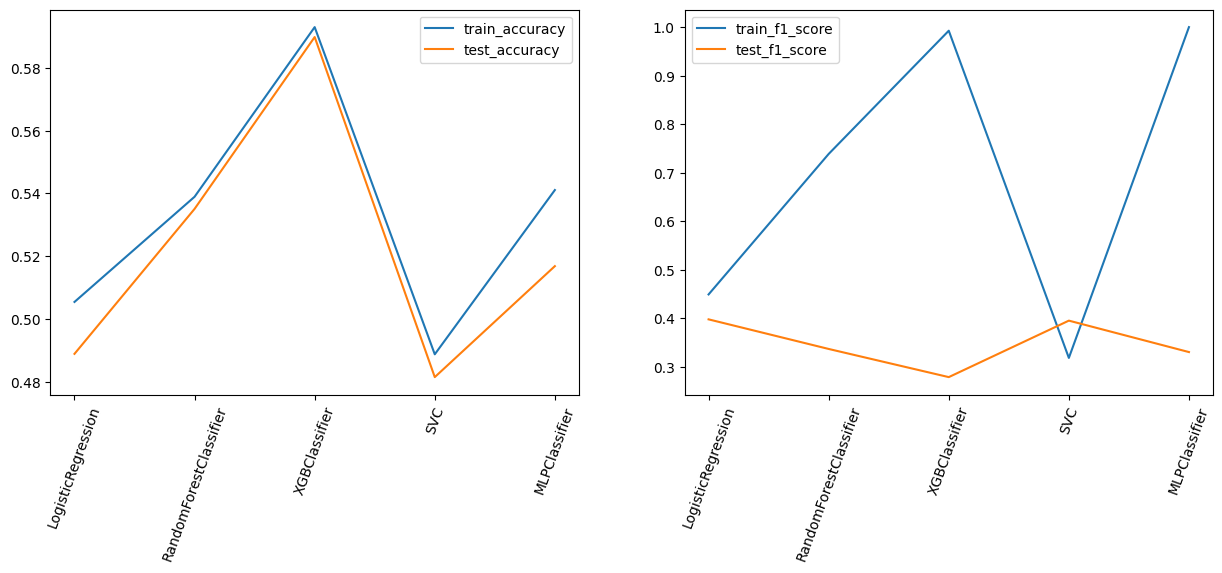

In [28]:
fig, axs = plt.subplots(1, 2, figsize=(15, 5))

axs[0].plot(Accuracies.keys(), [Accuracy[0] for Accuracy in Accuracies.values()], label = "train_accuracy")
axs[0].plot(Accuracies.keys(), [Accuracy[1] for Accuracy in Accuracies.values()], label = "test_accuracy")
axs[0].legend()
axs[0].tick_params(axis='x', labelrotation=70)

axs[1].plot(f1_scores.keys(), [f1[0] for f1 in f1_scores.values()], label = "train_f1_score")
axs[1].plot(f1_scores.keys(), [f1[1] for f1 in f1_scores.values()], label = "test_f1_score")
axs[1].legend()
axs[1].tick_params(axis='x', labelrotation=70)

plt.show()

The plot represent accuracy values as well as F1-score values for each model. We can see an inverse relationship between accuracy and F1-score. In fact, given that our classes are imbalanced (65% instances of class 0 and 35% of class 1), a model can achieve high accuracy by simply predicting the majority class for most instances. But the F1-score takes into account both precision and recall, providing a more balanced measure that considers false positives and false negatives. This is why F1-score can be a more informative metric.



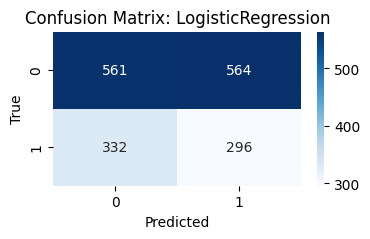

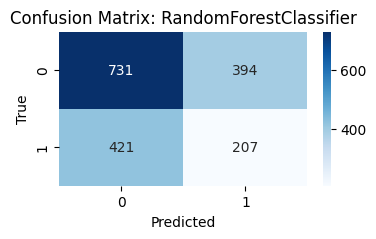

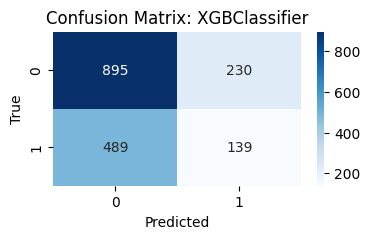

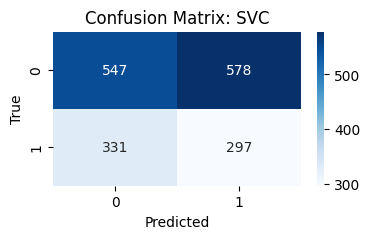

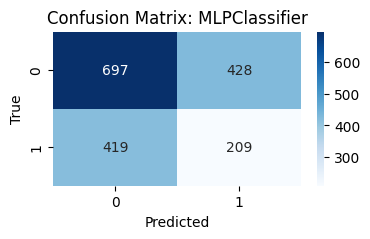

In [29]:
for i, cm in enumerate(conf_matrices):
   
    plt.figure(figsize=(4,2))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")

    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(f'Confusion Matrix: '+classifiers[i])

The plots represent the confusion matrices for each of the models. This help visualize the issue mentionned above for each model and help determine the models that can, indeed, make relatively better predictions.  

# Unsupervised learning

Let's use TSNE to see if we can distinguish clusters in our data

In [30]:
tsne = TSNE(n_components=3, n_iter=5000, random_state=42)
X_reduced = tsne.fit_transform(X_train)
df_tsne = pd.DataFrame(X_reduced)
df_tsne['c'] = pd.to_numeric(y_train).astype('Int64').to_list()

In [31]:
fig = px.scatter_3d(df_tsne,
                   x=0,
                   y=1,
                   z=2,
                   color='c',
                   title='Data distribution by classes',
                   log_x=True,
                   log_y=True,
                   log_z=True,
                   height=800,
                   width=800,
                   color_discrete_map={0: 'white', 1: 'red'})

fig.update_traces(marker_line_color = 'black',
                  marker_line_width = 2)

fig.show()

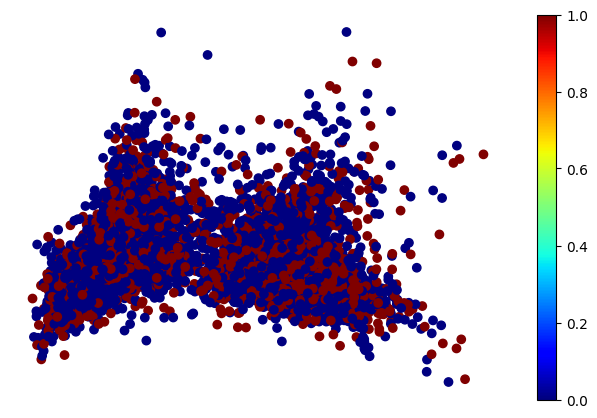

In [32]:
X_lle_reduced = LocallyLinearEmbedding(n_components=2, random_state=42).fit_transform(X_train)
plt.figure(figsize=(8,5))
plt.scatter(X_lle_reduced[:, 0], X_lle_reduced[:, 1], c=y_train, cmap="jet")
plt.axis('off')
plt.colorbar()
plt.show()

In both methods, we can see that there is a huge overlapping between the two clusters. This highlight the big difficulty of classifying patients even in a higher dimensional space

# Fine tuning SVC

As far as we're considering F1-score as our evaluation criteria, the best model is SVC. Let's finetune its hyperparameters using optuna

In [57]:
def objective(trial):

    C = trial.suggest_float('C', 1e-1, 1e3, log=True)
    degree = trial.suggest_int('degree', 2, 7)
    gamma = trial.suggest_categorical('gamma',['scale', 'auto'])
    model = SVC(C=C, kernel="sigmoid", degree=degree,class_weight='balanced', random_state=42, gamma=gamma)
    model.fit(X_train_pca, y_train)
    y_pred = model.predict(X_test_pca)
    score = f1_score(y_test, y_pred)
    return score

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)


[I 2023-12-07 22:33:13,183] A new study created in memory with name: no-name-ca330015-ae52-4792-9fa1-e417624e65fa
[I 2023-12-07 22:33:19,406] Trial 0 finished with value: 0.4005394470667566 and parameters: {'C': 18.554195757061322, 'degree': 7, 'gamma': 'scale'}. Best is trial 0 with value: 0.4005394470667566.
[I 2023-12-07 22:33:28,252] Trial 1 finished with value: 0.4141479099678457 and parameters: {'C': 4.011378276840413, 'degree': 4, 'gamma': 'auto'}. Best is trial 1 with value: 0.4141479099678457.
[I 2023-12-07 22:33:36,686] Trial 2 finished with value: 0.40735873850197113 and parameters: {'C': 0.6780475067440339, 'degree': 5, 'gamma': 'auto'}. Best is trial 1 with value: 0.4141479099678457.
[I 2023-12-07 22:33:44,604] Trial 3 finished with value: 0.3986798679867987 and parameters: {'C': 39.05216503459397, 'degree': 5, 'gamma': 'auto'}. Best is trial 1 with value: 0.4141479099678457.
[I 2023-12-07 22:33:50,492] Trial 4 finished with value: 0.396540252827678 and parameters: {'C': 8

Let's visualize the confusion matrix of our final model

0.43316195372750643


Text(0.5, 1.0, 'Confusion Matrix: SVC')

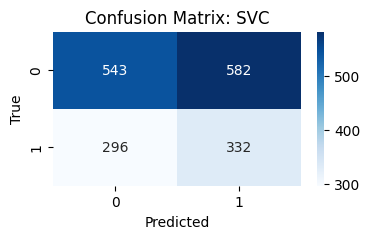

In [58]:
best_params = study.best_params
final_model = SVC(kernel="sigmoid",class_weight='balanced', random_state=42,**best_params)
final_model.fit(X_train_pca, y_train)
plt.figure(figsize=(4,2))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
y_pred = final_model.predict(X_test_pca)
cm = confusion_matrix(y_test, y_pred)
print(f1_score(y_test,y_pred))
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix: SVC')

# Features Importance

Let's see which features are the most important in the classification process

In [66]:
final_model = SVC(kernel="sigmoid",class_weight='balanced', random_state=42,**best_params)
final_model.fit(X_train, y_train)
y_pred = final_model.predict(X_test)
print(f1_score(y_test,y_pred))

0.4081632653061225


We can see that without pca we get a lower f1-score value

In [ ]:
result = permutation_importance(final_model, X_test, y_test, n_repeats=10, random_state=42, n_jobs=-1)

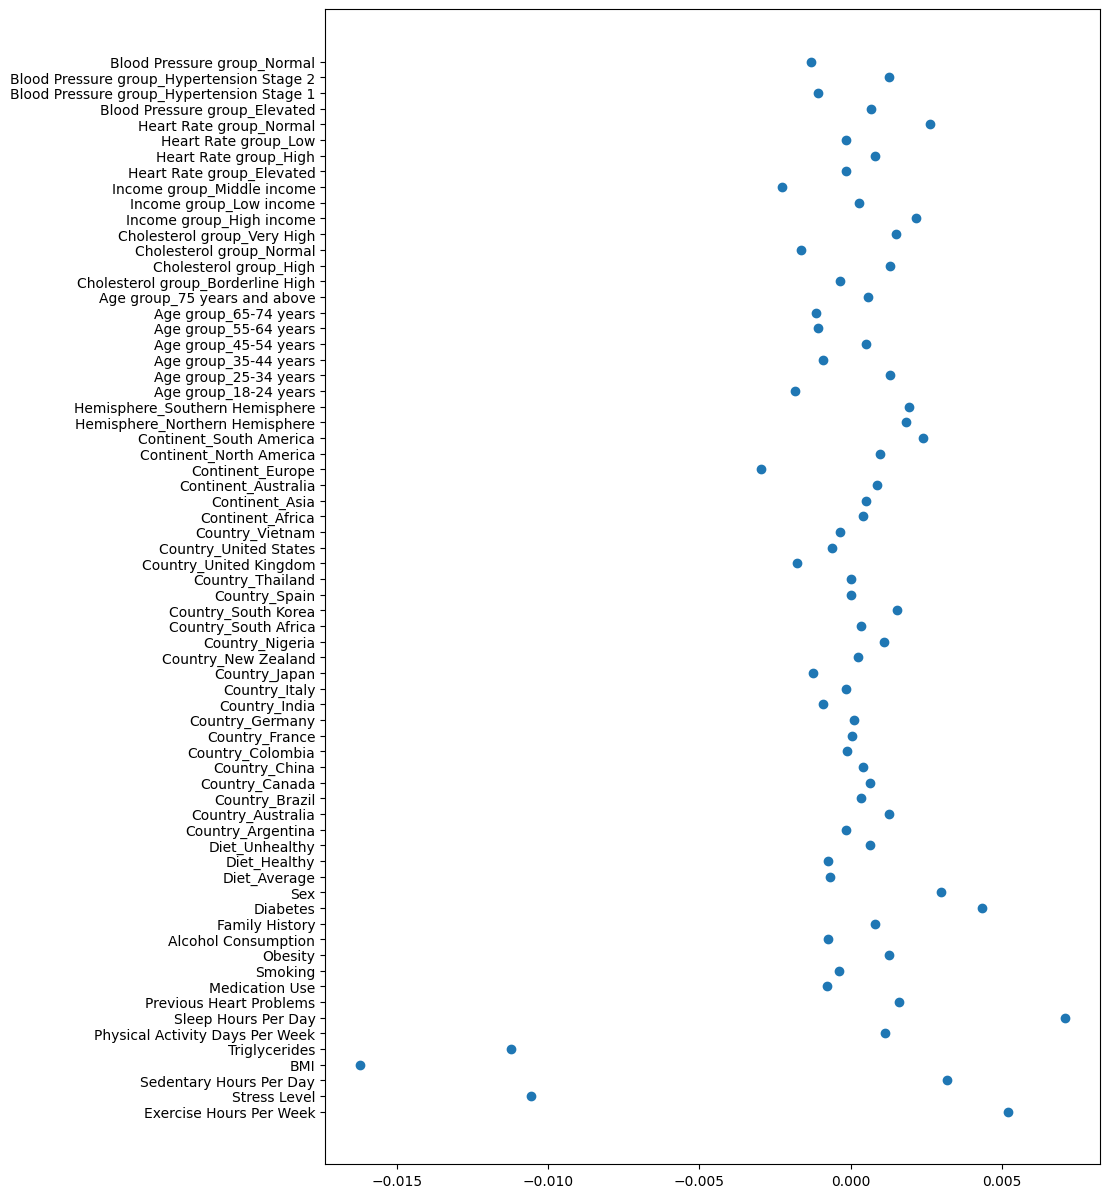

In [62]:
importances = pd.Series(result.importances_mean, index=data_encoded.columns)
plt.figure(figsize=(10,15))
plt.scatter(importances, data_encoded.columns)

In [64]:
combined_lists = list(zip(importances, data_encoded.columns))
sorted_combined = sorted(combined_lists, key=lambda x: abs(x[0]), reverse=True)

# Extract the top 3 elements and corresponding labels
top_3_elements = sorted_combined[:3]
top_3_values, top_3_labels = zip(*top_3_elements)

top_3_labels

('BMI', 'Triglycerides', 'Stress Level')

So we can distinguish 3 important features for our model:

1- BMI

2- Triglycerides

3- Stress level